In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

csv_path = Path("./Housing.csv")
df = pd.read_csv(csv_path)


target_col = 'price'


y = df[target_col].values
X = df.drop(columns=[target_col])

numeric_features = X.select_dtypes(include="number").columns.tolist()
categorical_features = X.select_dtypes(exclude="number").columns.tolist()

numeric_tf = Pipeline([("imputer", SimpleImputer(strategy="median"))])
categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_tf, numeric_features),
    ("cat", categorical_tf, categorical_features),
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Target:", target_col)
print("Numeric:", len(numeric_features), "| Categorical:", len(categorical_features))


Target: price
Numeric: 6 | Categorical: 6


In [2]:
rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline([
    ("prep", preprocess),
    ("rf", rf),
])

param_grid = {
    "rf__max_depth": [None, 10, 20],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 5],
    "rf__max_features": ["sqrt", "log2", 0.8],  # доля признаков
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(
    pipe, param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=cv, n_jobs=-1, verbose=0
)
gs.fit(X_train, y_train)
best_model = gs.best_estimator_
gs.best_params_


{'rf__max_depth': 20,
 'rf__max_features': 'sqrt',
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2}

In [3]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

# RF
y_pred_rf = best_model.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = rmse(y_test, y_pred_rf)

print("Random Forest")
print("Best params:", gs.best_params_)
print(f"R^2 (test): {r2_rf:.4f}")
print(f"RMSE (test): {rmse_rf:,.2f}")

# Для быстрого сравнения: базовое дерево решений
from sklearn.tree import DecisionTreeRegressor
tree_pipe = Pipeline([
    ("prep", preprocess),
    ("tree", DecisionTreeRegressor(random_state=42, max_depth=5, min_samples_split=10))
]).fit(X_train, y_train)

y_pred_tree = tree_pipe.predict(X_test)
print("\nDecision Tree (baseline)")
print(f"R^2 (test): {r2_score(y_test, y_pred_tree):.4f}")
print(f"RMSE (test): {rmse(y_test, y_pred_tree):,.2f}")


Random Forest
Best params: {'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2}
R^2 (test): 0.6461
RMSE (test): 15,376.25

Decision Tree (baseline)
R^2 (test): 0.3284
RMSE (test): 21,182.53


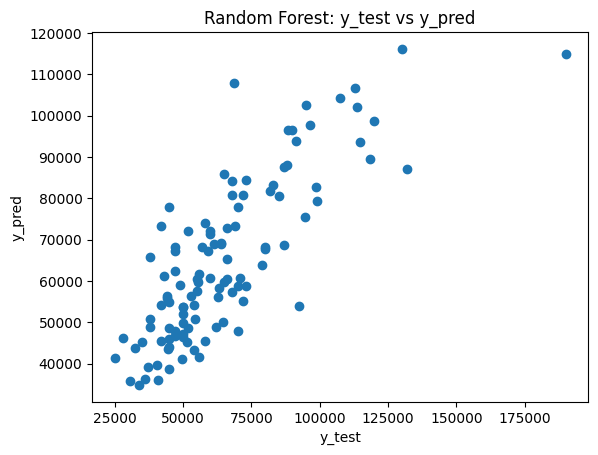

,feature,importance
1,lotsize,0.263302
0,rownames,0.167688
3,bathrms,0.109882
5,garagepl,0.076144
4,stories,0.062812
14,airco_no,0.062627
15,airco_yes,0.054482
2,bedrooms,0.052035
10,fullbase_no,0.020507
8,recroom_no,0.018896


In [4]:
# 4.1 scatter
plt.figure()
plt.scatter(y_test, y_pred_rf)
plt.title("Random Forest: y_test vs y_pred")
plt.xlabel("y_test"); plt.ylabel("y_pred")
plt.show()


oh = best_model.named_steps["prep"].transformers_[1][1].named_steps["onehot"] if categorical_features else None
num_names = numeric_features
cat_names = oh.get_feature_names_out(categorical_features).tolist() if oh is not None else []
feature_names = num_names + cat_names

importances = best_model.named_steps["rf"].feature_importances_
imp_df = pd.DataFrame({
    "feature": feature_names if len(feature_names)==len(importances) else [f"f{i}" for i in range(len(importances))],
    "importance": importances
}).sort_values("importance", ascending=False).head(15)

imp_df


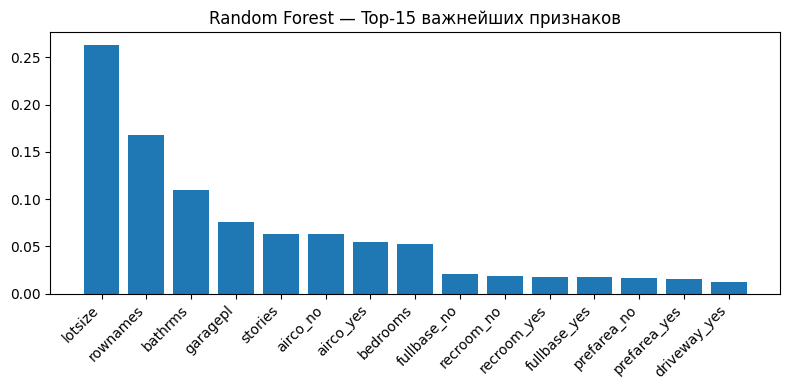

In [5]:
plt.figure(figsize=(8,4))
plt.bar(imp_df["feature"], imp_df["importance"])
plt.title("Random Forest — Top-15 важнейших признаков")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
